In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

1. Make dataset

1.1 Import dataset

In [2]:
X_base = torch.load('X.pt')
y_base = torch.load('y.pt')

X_base.shape, y_base.shape

FileNotFoundError: [Errno 2] No such file or directory: 'X.pt'

1.2 Shuffle Dataset

In [ ]:
torch.manual_seed(68)
perm = torch.randperm(X_base.size(0))
X = X_base[perm]
y = y_base[perm]

1.3 Split train and dev

In [ ]:
train_percent = 0.8
last_train_idx = int(train_percent * len(X))
X_train, y_train = X[:last_train_idx], y[:last_train_idx]
X_dev, y_dev = X[last_train_idx:], y[last_train_idx:]


X_train.shape, y_train.shape, X_dev.shape, y_dev.shape

(torch.Size([370, 6, 512]),
 torch.Size([370, 512]),
 torch.Size([93, 6, 512]),
 torch.Size([93, 512]))

1.4 Make into a torch dataset

In [ ]:
train_dataset = TensorDataset(X_train, y_train)

1.5 Make train loader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32)

2. Make model

In [ ]:
# class simple_segmenter(nn.Module):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.l0 = nn.Conv1d(6, 8, kernel_size=3, stride=2, padding=1)
#         self.l1 = nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1)
#         self.l2 = nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1)

#         self.l3 = nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1)
#         self.l4 = nn.ConvTranspose1d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.l5 = nn.ConvTranspose1d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.l0(x))
#         x = self.relu(self.l1(x))
#         ll = self.relu(self.l2(x))
        
#         x = self.relu(self.l3(ll))
#         x = self.relu(self.l4(x))
#         x = self.relu(self.l5(x))

#         return x


class DoubleConv(nn.Module):
    """(Conv1d -> ReLU -> Conv1d -> ReLU)"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=6, out_channels=1):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool1d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool1d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)

        # Decoder
        self.up3 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose1d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # Final output
        self.out = nn.Conv1d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))

        # Bottleneck
        x4 = self.bottleneck(self.pool3(x3))

        # Decoder
        x = self.up3(x4)
        x = self.dec3(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.dec2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))

        return self.out(x)

3. Make/Def Loss Function

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceBCELoss, self).__init__()
        self.smooth = smooth 
        
    def forward(self, inputs, targets):
        # Handle shape mismatch - squeeze the channel dimension if it's 1
        if inputs.dim() == 3 and inputs.size(1) == 1:
            inputs = inputs.squeeze(1)  # Remove channel dimension
        
        # Ensure targets are float and same shape as inputs
        targets = targets.float()
        if targets.shape != inputs.shape:
            targets = targets.view_as(inputs)
        
        # Use BCEWithLogitsLoss which applies sigmoid internally
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        # Apply sigmoid for Dice calculation
        inputs_sigmoid = torch.sigmoid(inputs)
        
        # Flatten tensors
        inputs_flat = inputs_sigmoid.view(-1)
        targets_flat = targets.view(-1)
        
        # Calculate Dice coefficient
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        
        # Combine losses
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

4. init The Important Stuff

In [ ]:
model = UNet1D()
criterion = DiceBCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

5. Created training loop

In [ ]:
lossi = []
devlossi = []
device = "cuda:0"
model = model.to(device=device)
X_dev, y_dev = X_dev.to(device=device), y_dev.to(device=device)

100%|██████████| 5/5 [00:00<00:00,  9.66it/s]


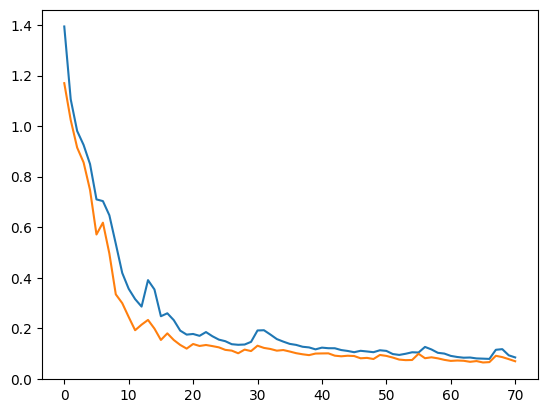

In [ ]:
for epoch in tqdm(range(5)):

    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device=device), y_batch.to(device=device)
        optimizer.zero_grad()
        train_logits = model(X_batch)
        loss = criterion(train_logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss +=  loss.item()

    lossi.append(total_loss / len(train_loader))

    #dev step 
    with torch.no_grad():
        model.eval()
        dev_logits =  model(X_dev)
        devloss = criterion(dev_logits, y_dev)
        devlossi.append(devloss.item())
    


plt.plot(lossi);
plt.plot(devlossi);
plt.show()

6. Eval

In [ ]:
X_dev_cpu = X_dev.cpu()
y_dev_cpu = y_dev.cpu()
dev_logits_cpu = (dev_logits.cpu() > 0.5).float()

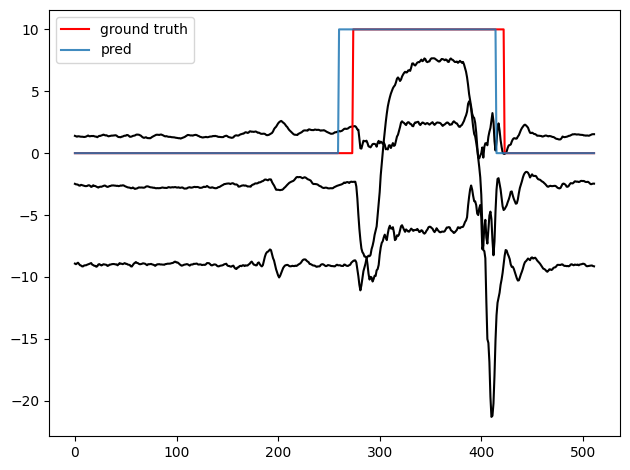

In [ ]:
idx = 30

plt.plot(X_dev_cpu[idx,0], c='black')
plt.plot(X_dev_cpu[idx,1], c='black')
plt.plot(X_dev_cpu[idx,2], c='black')
# plt.plot(X_dev_cpu[idx,3], c='black')
# plt.plot(X_dev_cpu[idx,4], c='black')
# plt.plot(X_dev_cpu[idx,5], c='black')
plt.plot(y_dev_cpu[idx] * 10, label='ground truth', color='red')
plt.plot(dev_logits_cpu[idx].squeeze() * 10, label='pred', alpha=0.85)

plt.legend()
plt.tight_layout()
plt.show()
